# Write-up notes

## Multi-class logistic regression

Multi-class logistic classfication is an extension of traditional logistic regression. The task goes from predicting a bernouli random variable to predicting one label to classifiy each example from a set of $k$ mutually exclusive labels. We encode the target $b_i \in \mathbb{R}^k$ where $k$ is the number of output classes to be a one hot vector, corresponding to the correct classification of eample $a_i \in \mathbb{R}^d$. It assignes these labels by learning the conditional probability distibution that the correct label is $b_i$ given example $a_i$ and learned parameter matrix $X \in \mathbb{R}^{d \times k}$ Where $d$ is the number of features in each example. The output distribution is computed with the softmax function in this context: 
$$p(b_i|a_i, X) = \frac{\exp(x_{b_i}^T a_i)}{\sum_{c=1}^k\exp(x_c^Ta_i)}$$
Multi-class logistic regression is a simple yet effective method with ubiquitous use. Its training does, however, require learning the parameter matrix $X$, which can be done using various methods like maximum likelihood or gradient descent based methods. This corresponds to solving the following optimization problem:
$$\min_{x\in\mathbb{R}^{d\times k}} \sum\limits_{i=1}^{m}[-x^T_{b_i}a_{i}+ \log(\sum\limits_{c=1}^k\exp(x_c^{T}a_i))]$$
which is the cross-entropy of the predicted class distribution and the target label $b_i$.  
In this report we will analyze the relative performance of various gradient methods at solving this probelm. Sepesifically, we are interested in comparing full gradient descent with block coordinate based methods (BCGD) which optimize one coordinate, or column in parameter matrix $X$, at a time.

## Algorithims
### Gradient Descent

### BCGD
What is the motivation of BCGD - I think it is exploiting convexity to make less work.  
Random rule - does not require calculating the full gradent, but only one block at at time. This saves work at each iteration, but can waste time selecting blocks that have already been optimized.  
Optimality conditions: check norm of gradient or block of gradient. if less than 0.01 stop. For random rule we use paticence, since selecting previously optimized blocks will have low gradient and would otherwise trigger stopping before convergence.  
Formally state the steps of each algorithim.  
Will probally discuss the results in the dataset sections.

Google if label asym ids should be conserved acrossed different mmCIF files

## Step-size
The more theoretical formulations for block coordinate descent methods use line searching to find an optimal point in the direction of the current gradient block. This does well to minimize the number of iterations for convergence by exploiting the convexity of the logistic classification problem. Should the cost cease to decrease over this line search, then a minima has been found on the line, and thus a block has been minimized. Here we visualize the loss over the linesearch along a gradient block selected at an iteration of BCGD with GS rule with varying step sizes on the synthetic dataset.  
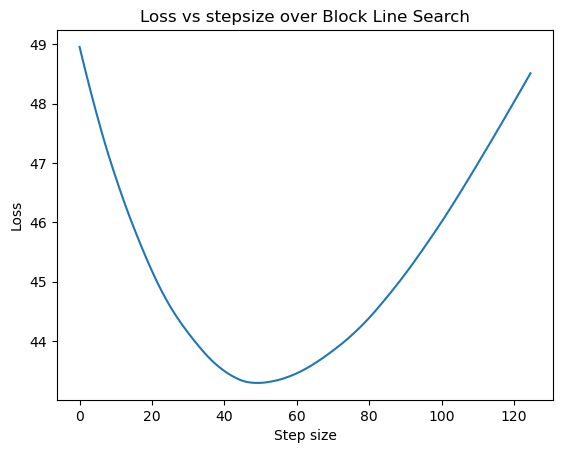  
In practice, computing he loss at many different points along this line to find the optimal step is a time expensive operation. Even if we use a corse search that on average, will only compute the loss an average of 5 times, we still observe BCGD with Gauss-Southwell rule taking approximately 3 times longer per iteration when using line searching rather than a fixed stepsize. 
This is illustrative of how expensive calculating the loss is in some applications. In this case, this would require calculating the product of $A$ and $X$, a $1000\times1000$, and $1000\times50$ matrix respectively, and taking soft-max. Where calculating the full gradient requires computing the same class probabilities and an additional product with the matrix $A$. When averaged over 100 calculations the computation times are as follows:  
||loss|Full Grad|Grad Block|
|-|-|-|-|
|CPU Time|0.0607|0.0437|0.0626|  
|Wall Time|0.0118|0.00887|0.0109|

These results are somewhat unexpected, that computing just a block of the gradient requires more time that the full gradient. Profiling our implementation, it seems both methods spend the majority of time calculating the class probabilities needed for both calculations and the difference between the two methods likely lies in numpys highly optimized matrix operations helping the full gradient calculation.

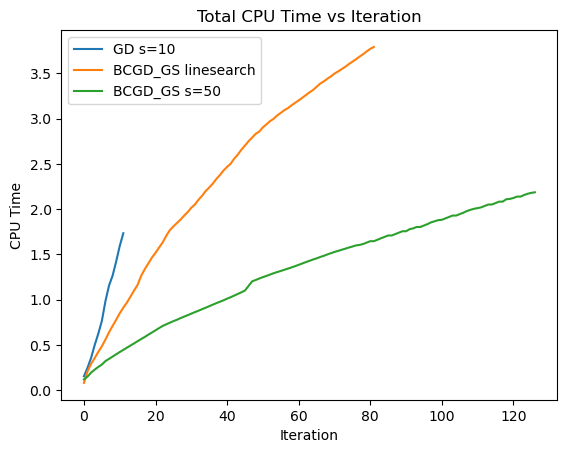  
The above plot displays the cumulative CPU time taken by the various methods at each iteration. Each algorithim was stopped once 100% accuracy was reached on the synthetic dataset, allowing comparison of CPU time taken to reach the same performace. Of note that though full gradient descent takes more time per iteration than either of the two BCGD with GS rule implementations, it was able to complete in less very little CPU time as a consequence of being able to minimize all blocks at once.
Though linesearching proved to be prohibitively expensive, we leveraged data gained from these runs to gain insight into the the problem of choosing an optimal learning rate for each iteration. 
The following plots display the step size selected by the linesearch BCGD with GS rule relative to iteration number and the magnitude of the gradient block at that iteration $G_{ik}$.  
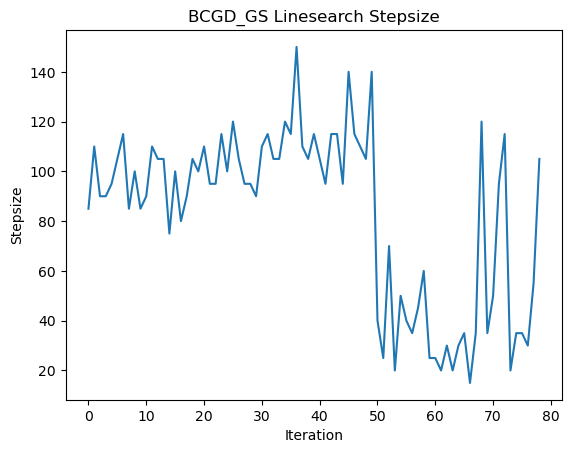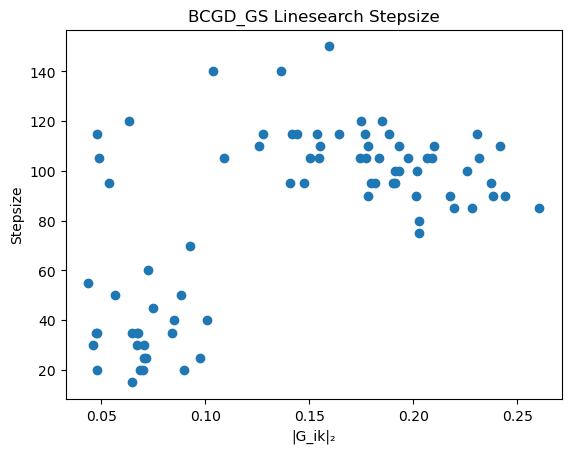
These plots clearly illustrate the inatequacy of fixed stepsized methods. 
This highlights the issue with fixed stepsize methods

Adaptave learning rate methods will incorporate information about gradient history, gradient size, or curvature in the loss function in order to take dynamic and more optimal steps at each iteration. 
Curvature 
Emperically estimating Lipshitz constant

Calculating the Lipchitz constant... Requires hessian. This is expensive. I think this would need to be done at each iteration, too. Can use approximation of lipshitz constant to create fixed stepsize that works well enough. Maybe mention adaptive rates. Reference slides for writing this section.

There are many approaches to approximating the Lipshitz constant. If this were to be done at every iteration, the major consideration is to balance the cost of estimating with estimation accuracy. This is of critical importance because The Lipshitz constant is dependent on the currant parameter matrix $X$, meaning the value of $L$ will change for each iteration, requiring recalculating. If this calculation is too costly, Block coordinate methods will loose any possible advantage they confer by having a less expensive gradient calculation, and too inpercise will cause instability and prevent the methods from converging.  
As a starting point we can consider our initialization of $X$ to have entries drawn from $N(0,1)$. Assuming sucessive steps to be drawn from the same distribution, we can estimate $L$ emperically with by sampeling many $A$ and $B$ and calculating:
$$L = \max_{A,B} \frac{||\nabla_X A - \nabla_X B||_2}{||A - B||_2}$$
Done on the synthetic dataset $X$ having standard normal distribution of entries we get $L = 6.93E-3$ and taking $s = \frac{1}{L}$, we get a stepsize of approximately 144. We note this value is within the range of many of the optimal stepsizes found with the linesearching BCGD_GS method. However, the assumption that the distribution of enteries in $X$ being standard normal at all iterations is not well founded as evidenced by the vanishing magnitude of the gradient as the model converges. We are then left with a good approximation of $L$ which gives a not too unreasonable fixed stepsize choice. This method to sample $A$ $B$ from the history of $X$ to create estimate using the real distributions of the parameters close to the current iteration, but we acknowladge this would be too costly to be effective.

## Syntetic Dataset
Gradient descent performs noticably better than both BCGD methods. We attribute this to the high-dimensionality of examples resulting in a large number of blocks that need to be individually optimized, where methods using the full gradient can decrease many of these at once.

## Real world data